In [1]:
from testproblems import random_problem_with_artifacts
from datastructures.operators import eqv_to_edges_tree, reformulate, invert_edges
from datastructures.graphutils import flat_graph_formulation, Node, COMP, VAR
from datastructures.rendering import render_incidence
from datastructures.tearing import min_max_scc2, min_arc_set_assign, min_arc_set, feedbacks
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

# Restructuring algorithms

In [2]:
m,n,seed,sparsity = 10, 12, 229, 4. 
kwargs = random_problem_with_artifacts(m,n,seed,sparsity, independent_of_n=True)

In [3]:
eq_incidence,outset,eqnidxs,edges_varonleft,varidxs = map(kwargs.get, ["eq_incidence","outset","eqnidxs","edges_varonleft","varidxs"])

## Calculated row density

In [4]:
np.mean([len(val) for val in eq_incidence.values()])

4.0

In [5]:
vizargs = {'figsize':(4,4), 'rotation':60, 'hideticks':True, 'fontsize':22, 'patchwidth':4}

## Undirected formulation

We see all sizing relationships as "equality constraints"

In [6]:
edges_undir,tree_undir,_ = eqv_to_edges_tree(eq_incidence, n_eqs=m)
edges_dir,tree_dir,outset_adj = eqv_to_edges_tree(eq_incidence, outset, n_eqs=m)
tree_undir[2].update({val:1 for val in outset_adj.values()})

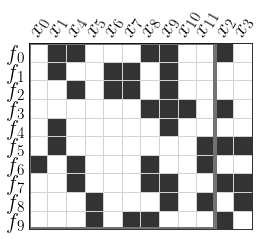

In [7]:
render_incidence(edges_undir, tree_undir, **vizargs);

## Directed formulation
Unstructured based on randomness

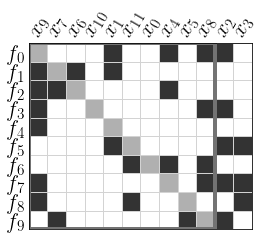

In [8]:
render_incidence(edges_dir, tree_dir, **vizargs);

## Polynomial restructuring algorithms

### Reformulated based on feedback from unstructured

In [9]:
D = flat_graph_formulation(*edges_dir)
fvars, fcomps = feedbacks(D, [Node(idx,COMP) for idx in eqnidxs])
outset_f = {comp:var for comp,var in outset.items() if Node(comp,COMP) not in fcomps}
edges_fb,tree_fb,_ = eqv_to_edges_tree(eq_incidence, outset_f, n_eqs=m)
tree_fb[2].update({v.name: 1 for v in sorted(fvars, key=lambda x: x.name)})

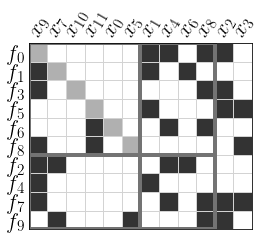

In [10]:
render_incidence(edges_fb, tree_fb, **vizargs);

### Condensation (Tarjan's algorithm)
Gives a topological sorting of the strongly connected components

#### Block reduce (subproblems)

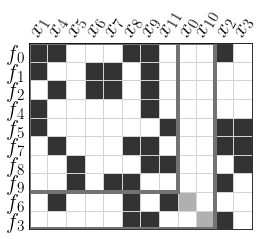

In [11]:
formulation_scc = reformulate(edges_dir, tree_dir, root_solver_name=1)
render_incidence(*formulation_scc, **vizargs);

#### Border reduce (no-subproblem)

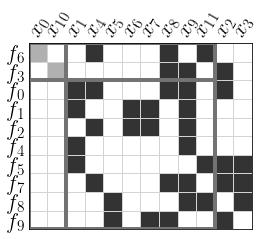

In [12]:
formulation_scc = reformulate(edges_dir, tree_dir, root_solver_name=1, mdf=False)
render_incidence(*formulation_scc, **vizargs);

### Fine Dumlage-Menelsohn decomposition

Returns the same formulation as Tarjan's algorithm

In [13]:
Ein_no_source = {comp:tuple(var for var in allvars if var in outset.values()) for comp,allvars in eq_incidence.items()}
G = flat_graph_formulation(Ein_no_source,{},{},{VAR: 'x_{{{}}}', COMP: 'f_{{{}}}'})
matching = nx.bipartite.maximum_matching(G)
m_out = {key: matching[Node(key, COMP)].name for key in eqnidxs}
edges_dir_m,tree_dir_m,_ = eqv_to_edges_tree(eq_incidence, m_out, n_eqs=m)

#### Block reduce (subproblems)

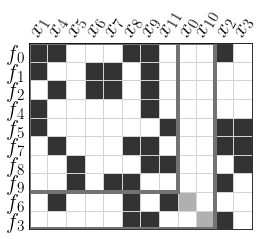

In [14]:
formulation_scc_m = reformulate(edges_dir_m, tree_dir_m, root_solver_name=1)
render_incidence(*formulation_scc_m, **vizargs);

#### Border reduce (no-subproblem)

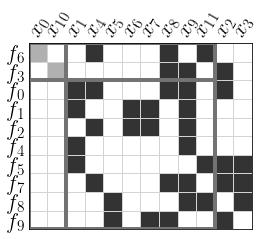

In [16]:
formulation_scc_m = reformulate(edges_dir_m, tree_dir_m, root_solver_name=1, mdf=False)
render_incidence(*formulation_scc_m, **vizargs);

## Optimization-based algorithms (NP-complete)

### Minimum Feedback Arc Set (FAS)

In [17]:
cycles, elimset, model = min_arc_set(edges_varonleft, outset, varidxs, eqnidxs)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [18]:
elimset, {outset_adj[elt] for elt in elimset}

({0, 1}, {7, 9})

In [19]:
outset_mfs = {key:val for key,val in outset_adj.items() if key not in elimset}

Compare to condensation (Tarjan's algorithm) results. Size of problem is reduced to 2.

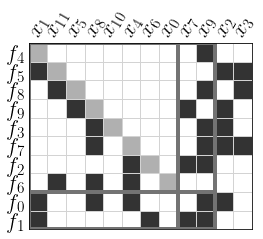

In [20]:
formulation_mfs = reformulate(edges_dir, tree_dir, outset_adj, outset_mfs, root_solver_name=1, solveforvars=2)
render_incidence(*formulation_mfs, **vizargs);

### Regular tearing

In this problem regular tearing does not do any better than FAS

In [21]:
fixed_inputs = set(varidxs)-set(outset.values())

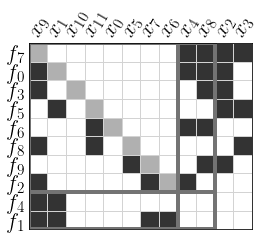

In [22]:
xsol, model = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs, not_output=fixed_inputs)
outset_tear = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
formulation_tear = reformulate(edges_dir, tree_dir, outset_adj, outset_tear, 
                               not_outputs={elt-m for elt in fixed_inputs},
                               root_solver_name=1)
render_incidence(*formulation_tear, **vizargs);

### Extended tearing

We change the inputs to be $x_8$ and $x_9$ and reduce the problem size further to 1

In [23]:
xsol, model = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs)
outset_minassign = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)

In [24]:
edges_minassign=invert_edges(edges_undir[0], edges_undir[1], outset_minassign) 

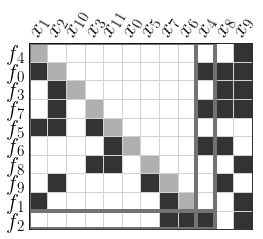

In [25]:
formulation_minassign = reformulate(edges_undir, tree_dir, outset_adj, outset_minassign, root_solver_name=1)
render_incidence(*formulation_minassign, **vizargs);

### Reduced subproblems

Compare results to condensation (Tarjan's algorithm) results with block reduce 

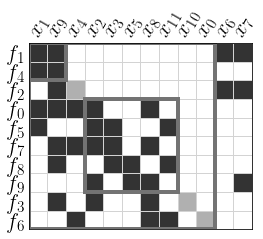

In [26]:
xsol, model = min_max_scc2(edges_varonleft, varidxs, eqnidxs)
outset_minscc = dict((right, left-m) for left, right in edges_varonleft if xsol[left, right] > 0.5)
formulation_minscc = reformulate(edges_dir, tree_dir, outset_adj, outset_minscc, root_solver_name=1)
render_incidence(*formulation_minscc, **vizargs);